In [1]:
from transformers import pipeline
from nltk import sent_tokenize
from glob import glob
import pandas as pd
import numpy as np
import nltk
import torch

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yotsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [2]:
# print("PyTorch version:", torch.__version__)
# print("Is MPS available (Mac GPU)?", torch.backends.mps.is_available())
# print("Is CUDA available?", torch.cuda.is_available())

model_name = "facebook/bart-large-mnli"

# for cpu device
# device = 0 if torch.cuda.is_available() else "cpu"

# for mac device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [3]:
def load_model(device):
  theme_classifier = pipeline(
    "zero-shot-classification",
    model = model_name,
    device = device
  )
  return theme_classifier

In [4]:
theme_classifier = load_model(device)

c:\Users\yotsa\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [6]:
theme_classifier(
  "I gave him a right hook then a left jab.",
  theme_list,
  multi_label=True,
)

{'sequence': 'I gave him a right hook then a left jab.',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9270268678665161,
  0.5092527270317078,
  0.09717556089162827,
  0.05300036817789078,
  0.016803039237856865,
  0.013136741705238819,
  0.007817934267222881,
  0.0034400583244860172]}

# Load dataset

In [7]:
files = glob("../data/Subtitles/*.ass")

In [8]:
files[:5]

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [9]:
with open(files[0], 'r') as file:
  lines = file.readlines()
  lines = lines[27:]
  lines = [",".join(line.split(',')[9:]) for line in lines]

In [10]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [11]:
lines = [line.replace('\\N', ' ') for line in lines]
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [12]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [13]:
int(files[0].split("-")[-1].split(".")[0].strip())

1

In [14]:
def load_subtitle_dataset(dataset_path):
  subtitles_paths = glob(dataset_path + '/*.ass')

  scripts = []
  episode_num = []

  for path in subtitles_paths:
    with open(path, 'r') as file:
      lines = file.readlines()
      lines = lines[27:]
      lines = [ ",".join(line.split(",")[9:]) for line in lines]

    lines = [line.replace('\\N', ' ') for line in lines]
    script = " ".join(lines)
    episode = int(path.split("-")[-1].split(".")[0].strip())

    scripts.append(script)
    episode_num.append(episode)

  df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
  return df

In [15]:
dataset_path = "../data/Subtitles"
df = load_subtitle_dataset(dataset_path)

In [16]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Run model

In [17]:
script = df.iloc[0]['script']

In [18]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [19]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [20]:
# batch sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
  sent = " ".join(script_sentences[index:index + sentence_batch_size])
  script_batches.append(sent)

In [21]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [22]:
theme_output = theme_classifier(
  script_batches[:2],
  theme_list,
  multi_label=True,
)

In [23]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800742268562317,
   0.9396901726722717,
   0.8546886444091797,
   0.7349815964698792,
   0.7284969091415405,
   0.199097916483879

In [24]:
# Wrangle output
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
  for label, score in zip(output["labels"], output["scores"]):
    if label not in themes:
      themes[label] = []
    themes[label].append(score)

themes = {
 key: np.mean(np.array(val)) for key, val in themes.items()
}

In [25]:
def get_theme_inference(script):
  script_sentences = sent_tokenize(script)

  # Batch sentence
  sentence_batch_size = 20
  script_batches = []
  for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index + sentence_batch_size])
    script_batches.append(sent)

  # Run model
  theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True,
  )

  # Wrangle output
  themes = {}
  for output in theme_output:
    for label, score in zip(output["labels"], output["scores"]):
      if label not in themes:
        themes[label] = []
      themes[label].append(score)

  themes = {
    key: np.mean(np.array(val)) for key, val in themes.items()
  }

  return themes

In [26]:
df = df.head(2)
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [27]:
output_themes = df['script'].apply(get_theme_inference)

In [28]:
output_themes

0    {'dialogue': 0.9585434198379517, 'betrayal': 0...
1    {'dialogue': 0.960606187582016, 'sacrifice': 0...
Name: script, dtype: object

In [29]:
theme_df = pd.DataFrame(output_themes.to_list())
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,0.960606,0.429944,0.684846,0.570703,0.482811,0.154534,0.046261,0.173261


In [30]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [31]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684846,0.570703,0.482811,0.154534,0.046261,0.173261


# Visualize output

In [32]:
df = df.drop('dialogue', axis=1)

In [33]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output


,theme,score
0,betrayal,1.222652
1,battle,1.441256
2,sacrifice,1.251137
3,self development,1.280970
4,hope,0.356202
5,friendship,0.118889
6,love,0.207402


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

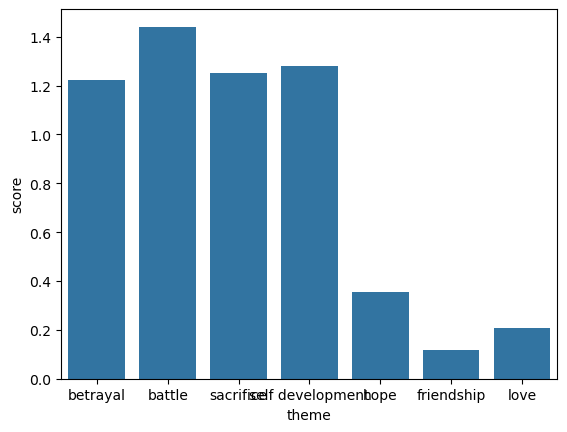

In [ ]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()